### Sentiment analysis

In [198]:
import nltk
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer
import re
from bs4 import BeautifulSoup
import json

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import pandas as pd
import numpy as np
import tarfile
import json
import matplotlib.pyplot as plt
from collections import Counter

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import spacy

In [2]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\Michael\AppDat

True

In [3]:
# Function that first rewrites certain patterns in a text to valid words and
# then tokenizes all the words the text.
def tweet_cleaner_updated(text):
    tok = WordPunctTokenizer()

    # Regexes used to rewrite certain patterns to valid words.
    pat1 = r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+'
    pat2 = r'https?://[^ ]+'
    combined_pat = r'|'.join((pat1, pat2))
    www_pat = r'www.[^ ]+'
    negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                    "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                    "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                    "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                    "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

    # Tokenize words.
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip().split(' ')

def tweet_cleaner_updated_selection(text):
    tok = WordPunctTokenizer()

    # Regexes used to rewrite certain patterns to valid words.
    pat2 = r'https?://[^ ]+'
    www_pat = r'www.[^ ]+'
    negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                    "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                    "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                    "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                    "mustn't":"must not"}
    neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

    # Tokenize words.
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(pat2, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip().split(' ')

def stemmer(df):
    ps = PorterStemmer()
    sentenceList = df['text_clean'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))
    wordsList = sentenceList.apply(lambda x: x.split())
    df['text_stemmed'] = wordsList

def lemmer(df):
    lmtzr = WordNetLemmatizer()
    sentenceList = df['text_clean'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))
    wordsList = sentenceList.apply(lambda x: x.split())
    df['text_lemmed'] = wordsList

def word_feats(words):
    return dict([(word, True) for word in words])

def word_feats_tweet(strng):
    temp = tweet_cleaner_updated(strng)
    return word_feats(temp)

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words)
    return features

In [4]:
def classifier_training(file):
    sentiment_training = pd.read_csv(file)[['sentiment', 'text']]
    sent_pos = sentiment_training[sentiment_training['sentiment'] == 4]['text']
    sent_neg = sentiment_training[sentiment_training['sentiment'] == 0]['text']
    sent_pos_clean = list(sent_pos.apply(tweet_cleaner_updated))
    sent_neg_clean = list(sent_neg.apply(tweet_cleaner_updated))
    negfeats = [(word_feats(sent_neg_clean[i]), 'neg') for i in range(len(sent_neg_clean))]
    posfeats = [(word_feats(sent_pos_clean[i]), 'pos') for i in range(len(sent_pos_clean))]
    negcutoff = int(len(negfeats)*0.75)
    poscutoff = int(len(posfeats)*0.75)
    
    # Construct the training dataset containing 50% positive reviews and 50% negative reviews
    trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]

    # Construct the negative dataset containing 50% positive reviews and 50% negative reviews
    testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]

    print ('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

    # Train a NaiveBayesClassifier
    classifier = NaiveBayesClassifier.train(trainfeats)

    # Test the trained classifier and display the most informative features.
    print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
    classifier.show_most_informative_features()
    
    return classifier

In [6]:
classifier = classifier_training('sentiment_2.csv')

train on 8655 instances, test on 2886 instances
accuracy: 0.8801108801108801
Most Informative Features
                    rock = True              pos : neg    =     39.6 : 1.0
                favorite = True              pos : neg    =     34.9 : 1.0
                passbook = True              pos : neg    =     34.9 : 1.0
                 worries = True              pos : neg    =     32.4 : 1.0
               beautiful = True              pos : neg    =     27.2 : 1.0
                  prompt = True              pos : neg    =     24.6 : 1.0
                   raise = True              pos : neg    =     24.6 : 1.0
                 awesome = True              pos : neg    =     21.4 : 1.0
                     hrs = True              neg : pos    =     21.0 : 1.0
                    hold = True              neg : pos    =     20.9 : 1.0


The model is able to train a model based on the airline data with an accuracy of nearly 0.9. This is promising, but doesn't provide any garanties for other types of data

### Model on US Election data
The next step is to use the newly trained classifier on the actual dataset. As a first step, the whole dataset is split into tweets mentioning Hillary, Trump or both.

In [121]:
# Function returns dict with tweets from file: "fileName".
def loadTweets(fileName = 'geotagged_tweets_20160812-0912.jsons', length = 9999999):
    counter = 0
    tweets_dict = {}
    with open('geotagged_tweets_20160812-0912.jsons') as fd:
        for line in tqdm_notebook(fd):
            j_content = json.loads(line)
            text = j_content['text']
            try:
                country = j_content['place']['country_code']
                location = j_content['place']['full_name']
            except:
                pass
            timestamp = j_content['created_at']
            tweets_dict[counter] = [timestamp, location, country, text]
            counter += 1
            if counter == length: # to keep it  small
                break
    return pd.DataFrame.from_dict(tweets_dict, orient='index').rename(columns={0:'timestamp', 1:'location', 2:'country', 3: 'text'})

def tweets_to_candidates(df):
    """
    This function takes a dataframe of tweets as input.
    It select entries that react to either Trump, Hillary or both.
    It then places the tweet text of the  entries in the corresponding dictionary.
    This is the tweet text as a list entry with the tweeters state as key.
    The output is a dict with 3 dicts (both, trump, hillary) with all states as keys and the tweets from that state as valeus.

    """
    both_df = pd.DataFrame(columns=df.columns)
    trump_df = pd.DataFrame(columns=df.columns)
    hillary_df = pd.DataFrame(columns=df.columns)
    df['text'] = df['text'].apply(tweet_cleaner_updated_selection)
    for i in tqdm_notebook(range(df.shape[0])):
        if df.iloc[i]['country'] == 'US':
            if any(s in df['text'].iloc[i] for s in ['realdonaldtrump', 'trump', 'donald', 'donaldtrump'])\
            and any(s in df['text'].iloc[i] for s in['hillaryclinton','hillary','clinton']):
                both_df = both_df.append(df.iloc[i], ignore_index=True)
            elif any(s in df['text'].iloc[i] for s in ['realdonaldtrump', 'trump', 'donald', 'donaldtrump']):
                trump_df = trump_df.append(df.iloc[i], ignore_index=True)
            elif any(s in df['text'].iloc[i] for s in['hillaryclinton','hillary','clinton']):
                hillary_df = hillary_df.append(df.iloc[i], ignore_index=True)
            else:
#                 print(df.iloc[i]['text'])
                pass
    return both_df, trump_df, hillary_df

def score_per_selection(df):
    """
    Function that gives a score of the sentiment of a selection of tweets
    Positive scores are indicators of postive sentiment, and negative scores for negative sentiment.
    The returned score is the average score, so total sentiment/#tweets
    """
    tweets_lst = list(df['text'])
    test_features = [word_feats(tweet) for tweet in tweets_lst]
    score = 0
    for tweet in test_features:
        if classifier.classify(tweet) =='pos':
            score += 1 # since most neutral tweets are considered negative
        else:
            score -= 1
    return score/df.shape[0]

def location_to_state_abb(location):
    abbreviation = location[-2:]
    if abbreviation == 'SA':
        try:
            abbreviation = transform_dict[location]
        except:
            pass
    return abbreviation
            
transform_dict = {'New York, USA': 'NY', 'New Jersey, USA': 'NJ', 'Pennsylvania, USA': 'PA', 'Georgia, USA': 'GA','Iowa, USA': 'IA', 'Virginia, USA': 'VA', 'Missouri, USA':'MO', 'Alabama, USA': 'AL','North Carolina, USA': 'NC', 'Illinois, USA': 'IL', 'Texas, USA': 'TX', 'Florida, USA': 'FL','Maryland, USA': 'MD', 'Kentucky, USA': 'KY', 'Arkansas, USA': 'AR', 'Alaska, USA': 'AK', 'Kansas, USA': 'KS', 'South Carolina, USA': 'SC', 'Louisiana, USA': 'LA', 'Maine, USA': 'ME', 'Michigan, USA': 'MI', 'Wisconsin, USA': 'WI', 'Delaware, USA': 'DE', 'Arizona, USA': 'AZ', 'Mississippi, USA': 'MS', 'Indiana, USA': 'IN', 'Ohio, USA': 'OH'}

def candidates_to_states(df, transformation_dict = transform_dict):
    """
    transforms a dataframe to a dictionary of dataframes with the state abbrevation being the key and a dataframe
    of tweets from that state as value.
    """
    df['state_abb'] = df['location'].apply(location_to_state_abb)
    states_dict = {}
    for state in df['state_abb'].unique():
        states_dict[state] = df[df['state_abb'] == state]
    return states_dict

def score_per_state(dict_with_dfs):
    score_dict = {}
    for key, values in dict_with_dfs.items():
        score_dict[key] = score_per_selection(dict_with_dfs[key])
    return score_dict

In [9]:
df = loadTweets(length=50000)
both, trump, hillary = tweets_to_candidates(df)
print(both.shape, trump.shape, hillary.shape)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://t.co/WSqOvs7udW" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://t.co/mihWNnCpfe

@CNN" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "https://t.co/abmHfDq5ut

@realDonaldTrump" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful So


(4664, 4) (25928, 4) (6870, 4)


From the data set, it is clearly seen that all data can be classified as being on both candidates or just on Trump. The Hillary df has no entries en the else clause does not print anything.

In [122]:
print(score_per_selection(both))
print(score_per_selection(trump))
print(score_per_selection(hillary))

-0.9000857632933105
-0.8672477630361
-0.8724890829694323


In [473]:
tweets_lst_trump = list(trump['text'])
test_features_trump = [word_feats(x) for x in tweets_lst_trump]
score_list_trump = []
for tweet in test_features_trump:
    if classifier.classify(tweet) =='pos':
        score_list_trump.append(1) # since most neutral tweets are considered negative
    else:
        score_list_trump.append(0)
trump['positive'] = score_list_trump        
        
tweets_lst_hillary = list(hillary['text'])
test_features_hillary = [word_feats(x) for x in tweets_lst_hillary]
score_list_hillary = []
for tweet in test_features_hillary:
    if classifier.classify(tweet) =='pos':
        score_list_hillary.append(1) # since most neutral tweets are considered negative
    else:
        score_list_hillary.append(0)

hillary['positive'] = score_list_hillary        

tweets_lst_both = list(both['text'])
test_features_both = [word_feats(x) for x in tweets_lst_both]
score_list_both = []
for tweet in test_features_both:
    if classifier.classify(tweet) =='pos':
        score_list_both.append(1) # since most neutral tweets are considered negative
    else:
        score_list_both.append(0)
        
both['positive'] = score_list_both        


In [474]:
trump_per_state = score_per_state(candidates_to_states(trump))
hillary_per_state = score_per_state(candidates_to_states(hillary))
both_per_state = score_per_state(candidates_to_states(both))

#################### TEST ##################
trump_test = candidates_to_states(trump)['NY'].head(50)
print(score_per_selection(trump_test))
print('###########')
hillary_test = candidates_to_states(hillary)['NY'].head(50)
print(score_per_selection(hillary_test))

-0.92
###########
-0.96


In [480]:
import os
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
from matplotlib import cm
import math

def intensity_creator(dct):
    import operator
    temp = max(dct.items(), key=operator.itemgetter(1))[0]
    return dct[temp]
        

def create_map(dct, colormap='bwr', diff=False):
    S_DIR = '' 
    BLUE = '#5599ff'
    cmap = plt.get_cmap(colormap) # Choose a colormap to be used to color

    with open(os.path.join(S_DIR, 'states.json')) as rf:    
        data = json.load(rf)

    fig = plt.figure() 
    ax = fig.gca()
    for feature in data['features']:
        geometry = feature['geometry']

        # Convert population to a proportion of the maximum value
        name = feature['properties']['STATE_ABBR']
        if diff:
            try:
                if dct[name] > 0:
                    intensity = 0.9999
                else:
                    intensity = 0
            except:
                intensity = 9999
        elif not diff:
            try:
                intensity = 1- math.sqrt((dct[name] + 1)/2)
            
            except:
                intensity = 9999

        if geometry['type'] == 'Polygon':
            poly = geometry
            ppatch = PolygonPatch(poly, fc=cmap(intensity), ec='black',  alpha=0.5, zorder=2)
            ax.add_patch(ppatch)

        elif geometry['type'] == 'MultiPolygon':
            for polygon in geometry['coordinates'][0]:
                poly = Polygon(polygon)
                ppatch = PolygonPatch(poly, fc=cmap(intensity), ec='black', alpha=0.5, zorder=2)
                ax.add_patch(ppatch)
        else:
            print('Don\'t know how to draw :', geometry['type'])

    ax.axis('scaled')
    plt.axis('off')
    plt.show()

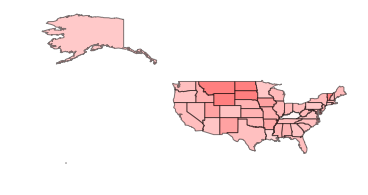

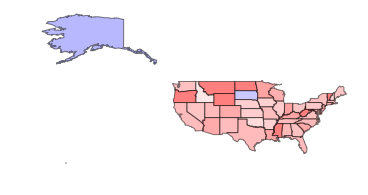

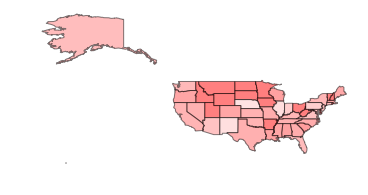

In [481]:
create_map(trump_per_state)
create_map(hillary_per_state)
create_map(both_per_state)

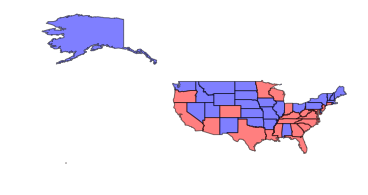

In [482]:
d3 = {key: trump_per_state[key] - hillary_per_state.get(key, 0) for key in trump_per_state.keys()}
create_map(d3, diff=True)

In [484]:
#df_test_data=pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None)[[0,5]].rename(columns={0:'sentimennt', 5:'text'})
#df_test_data.to_csv(path_or_buf='sentiment_2.csv', index=False)
#df_test_data.head()

# Topic analysis

For every tweet labeled positive and negative we want to label the topics that were discussed within them.

First we will label each candidate's sentiment wheter it was positive or negative. Then we make for these 6 categories each their own list of texts, then we clean the data of these texts. We lemmetize these texts and then we use the LDA algorithm for topic analysis over these 6 categories. Then we visualize our results using a library pyLDAvis which allow us to see if the topics overlap and judge how much topics our LDA algorithm would need to use. It also gives us insight into the topics. 

In [ ]:
tweets_lst_trump = list(trump['text'])
test_features_trump = [word_feats(x) for x in tweets_lst_trump]
score_list_trump = []
for tweet in test_features_trump:
    if classifier.classify(tweet) =='pos':
        score_list_trump.append(1) # since most neutral tweets are considered negative
    else:
        score_list_trump.append(0)
trump['positive'] = score_list_trump        
        
tweets_lst_hillary = list(hillary['text'])
test_features_hillary = [word_feats(x) for x in tweets_lst_hillary]
score_list_hillary = []
for tweet in test_features_hillary:
    if classifier.classify(tweet) =='pos':
        score_list_hillary.append(1) # since most neutral tweets are considered negative
    else:
        score_list_hillary.append(0)

hillary['positive'] = score_list_hillary        

tweets_lst_both = list(both['text'])
test_features_both = [word_feats(x) for x in tweets_lst_both]
score_list_both = []
for tweet in test_features_both:
    if classifier.classify(tweet) =='pos':
        score_list_both.append(1) # since most neutral tweets are considered negative
    else:
        score_list_both.append(0)
        
both['positive'] = score_list_both   

In [386]:
trump_text_positive = trump[['text']][trump['positive'] == 1]
trump_text_negative = trump[['text']][trump['positive'] == 0]
hillary_text_positive = hillary[['text']][hillary['positive'] == 1]
hillary_text_negative = hillary[['text']][hillary['positive'] == 0]
both_text_positive = both[['text']][both['positive'] == 1]
both_text_negative = both[['text']][both['positive'] == 0]

#trump_text_positive['text'] = trump_text_positive['text'].astype('|S80')
#trump_text_positive['text'].dtype

In [387]:
#trump_text_positive =  [re.sub("[^a-zA-Z]",'', str(x)) for x in trump_text_positive]
#trump_text_positive =  [re.sub(r'[^a-zA-Z]','', trump_text_positive)]
#trump_text_positive['liststring']=trump_text_positive.apply(lambda x: ', '.join(str(x)))
trump_text_positive['text'] = [','.join(map(str, l)) for l in trump_text_positive['text']]
trump_text_negative['text'] = [','.join(map(str, l)) for l in trump_text_negative['text']]
hillary_text_positive['text'] = [','.join(map(str, l)) for l in hillary_text_positive['text']]
hillary_text_negative['text'] = [','.join(map(str, l)) for l in hillary_text_negative['text']]
both_text_positive['text'] = [','.join(map(str, l)) for l in both_text_positive['text']]
both_text_negative['text'] = [','.join(map(str, l)) for l in both_text_negative['text']]

#trump_text_positive['text'] =  trump_text_positive['text'].apply(lambda x: re.sub('[^a-zA-Z]',' ', str(x)))

#trump_text_positive = [','.join(map(str, l)) for l in trump_text_positive]
#trump_text_positive

In [388]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use','be','have','make','do','need','come','want','when','not'
                      ,'know','get','go','thing','say'])
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1 and x not in stop_words]
    return (" ".join(words)).strip()

In [389]:
trump_positive_result = []
trump_negative_result = []
hillary_positive_result = []
hillary_negative_result = []
both_positive_result = []
both_negative_result = []

for t in trump_text_positive['text']:
    trump_positive_result.append(tweet_cleaner_updated(t))
trump_text_positive['text'] = trump_positive_result

for t in trump_text_negative['text']:
    trump_negative_result.append(tweet_cleaner_updated(t))
trump_text_negative['text'] = trump_negative_result

for t in hillary_text_positive['text']:
    hillary_positive_result.append(tweet_cleaner_updated(t))
hillary_text_positive['text'] = hillary_positive_result

for t in hillary_text_negative['text']:
    hillary_negative_result.append(tweet_cleaner_updated(t))
hillary_text_negative['text'] = hillary_negative_result

for t in both_text_positive['text']:
    both_positive_result.append(tweet_cleaner_updated(t))
both_text_positive['text'] = both_positive_result

for t in both_text_negative['text']:
    both_negative_result.append(tweet_cleaner_updated(t))
both_text_negative['text'] = both_negative_result


In [427]:
bigram_trump_positive = gensim.models.Phrases(trump_text_positive['text'], min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_trump_negative = gensim.models.Phrases(trump_text_negative['text'][:2000], min_count=5, threshold=100)
bigram_hillary_positive = gensim.models.Phrases(hillary_text_positive['text'][:2000], min_count=5, threshold=100)
bigram_hillary_negative = gensim.models.Phrases(hillary_text_negative['text'][:2000], min_count=5, threshold=100)
bigram_both_positive = gensim.models.Phrases(both_text_positive['text'][:2000], min_count=5, threshold=100)
bigram_both_negative = gensim.models.Phrases(both_text_negative['text'][:2000], min_count=5, threshold=100)



bigram_mod_trump_positive = gensim.models.phrases.Phraser(bigram_trump_positive)
bigram_mod_trump_negative = gensim.models.phrases.Phraser(bigram_trump_negative)
bigram_mod_hillary_positive = gensim.models.phrases.Phraser(bigram_hillary_positive)
bigram_mod_hillary_negative = gensim.models.phrases.Phraser(bigram_hillary_negative)
bigram_mod_both_positive = gensim.models.phrases.Phraser(bigram_both_positive)
bigram_mod_both_negative = gensim.models.phrases.Phraser(bigram_both_negative)


def make_bigrams_trump_pos(texts):
    return [bigram_mod_trump_positive[doc] for doc in texts]

def make_bigrams_trump_neg(texts):
    return [bigram_mod_trump_negative[doc] for doc in texts]

def make_bigrams_hillary_pos(texts):
    return [bigram_mod_hillary_positive[doc] for doc in texts]

def make_bigrams_hillary_neg(texts):
    return [bigram_mod_hillary_negative[doc] for doc in texts]

def make_bigrams_both_pos(texts):
    return [bigram_mod_both_positive[doc] for doc in texts]

def make_bigrams_both_neg(texts):
    return [bigram_mod_both_negative[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp("".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [430]:
nlp = spacy.load('en', disable=['parser', 'ner'])

data_words_bigrams_trump_pos = make_bigrams_trump_pos(trump_text_positive['text'])
data_lemmatized_trump_pos = lemmatization(data_words_bigrams_trump_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_trump_neg = make_bigrams_trump_neg(trump_text_negative['text'][:2000])
data_lemmatized_trump_neg = lemmatization(data_words_bigrams_trump_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_hillary_pos = make_bigrams_hillary_pos(hillary_text_positive['text'][:2000])
data_lemmatized_hillary_pos = lemmatization(data_words_bigrams_hillary_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_hillary_neg = make_bigrams_hillary_neg(hillary_text_negative['text'][:2000])
data_lemmatized_hillary_neg = lemmatization(data_words_bigrams_hillary_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_both_pos = make_bigrams_both_pos(both_text_positive['text'][:2000])
data_lemmatized_both_pos = lemmatization(data_words_bigrams_both_pos, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_words_bigrams_both_neg = make_bigrams_both_neg(both_text_negative['text'][:2000])
data_lemmatized_both_neg = lemmatization(data_words_bigrams_both_neg, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [431]:
len(data_lemmatized_trump_neg)

2000

In [432]:
# Create Dictionary
id2word_trump_pos = corpora.Dictionary(data_lemmatized_trump_pos)
id2word_trump_neg = corpora.Dictionary(data_lemmatized_trump_neg)
id2word_hillary_pos = corpora.Dictionary(data_lemmatized_hillary_pos)
id2word_hillary_neg = corpora.Dictionary(data_lemmatized_hillary_pos)
id2word_both_pos = corpora.Dictionary(data_lemmatized_both_pos)
id2word_both_neg = corpora.Dictionary(data_lemmatized_both_neg)



# Create Corpus
texts_trump_pos = data_lemmatized_trump_pos
texts_trump_neg = data_lemmatized_trump_neg
texts_hillary_pos = data_lemmatized_hillary_pos
texts_hillary_neg = data_lemmatized_hillary_neg
texts_both_pos = data_lemmatized_both_pos
texts_both_neg = data_lemmatized_both_neg


# Term Document Frequency
corpus_trump_pos = [id2word_trump_pos.doc2bow(text) for text in texts_trump_pos]
corpus_trump_neg = [id2word_trump_neg.doc2bow(text) for text in texts_trump_neg]
corpus_hillary_pos = [id2word_hillary_pos.doc2bow(text) for text in texts_hillary_pos]
corpus_hillary_neg = [id2word_hillary_neg.doc2bow(text) for text in texts_hillary_neg]
corpus_both_pos = [id2word_both_pos.doc2bow(text) for text in texts_both_pos]
corpus_both_neg = [id2word_both_neg.doc2bow(text) for text in texts_both_neg]


In [459]:
# Build LDA model
lda_model_trump_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_trump_pos,
                                           id2word=id2word_trump_pos,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [460]:
# Build LDA model
lda_model_trump_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_trump_neg,
                                           id2word=id2word_trump_neg,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [461]:
# Build LDA model
lda_model_hillary_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_hillary_pos,
                                           id2word=id2word_hillary_pos,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [462]:
# Build LDA model
lda_model_hillary_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_hillary_neg,
                                           id2word=id2word_hillary_neg,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [463]:
# Build LDA model
lda_model_both_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_both_pos,
                                           id2word=id2word_both_pos,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [464]:
# Build LDA model
lda_model_both_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_both_neg,
                                           id2word=id2word_both_neg,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [452]:
# Print the Keyword in the 10 topics
#print(lda_model_trump_pos.print_topics())
#doc_lda = lda_model_trump_pos[corpus]

In [453]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_trump_pos.log_perplexity(corpus_trump_pos))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_trump_pos = CoherenceModel(model=lda_model_trump_pos, texts=data_lemmatized_trump_pos, dictionary=id2word_trump_pos, coherence='c_v')
coherence_lda_trump_pos = coherence_model_lda_trump_pos.get_coherence()
print('\nCoherence Score: ', coherence_lda_trump_pos)

# Compute Perplexity
print('\nPerplexity: ', lda_model_trump_neg.log_perplexity(corpus_trump_neg))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_trump_neg = CoherenceModel(model=lda_model_trump_neg, texts=data_lemmatized_trump_neg, dictionary=id2word_trump_neg, coherence='c_v')
coherence_lda_trump_neg = coherence_model_lda_trump_neg.get_coherence()
print('\nCoherence Score: ', coherence_lda_trump_neg)

# Compute Perplexity
print('\nPerplexity: ', lda_model_hillary_pos.log_perplexity(corpus_hillary_pos))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_hillary_pos = CoherenceModel(model=lda_model_hillary_pos, texts=data_lemmatized_hillary_pos, dictionary=id2word_hillary_pos, coherence='c_v')
coherence_lda_hillary_pos = coherence_model_lda_hillary_pos.get_coherence()
print('\nCoherence Score: ', coherence_lda_hillary_pos)

# Compute Perplexity
print('\nPerplexity: ', lda_model_hillary_neg.log_perplexity(corpus_hillary_neg))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_hillary_neg = CoherenceModel(model=lda_model_hillary_neg, texts=data_lemmatized_hillary_neg, dictionary=id2word_hillary_neg, coherence='c_v')
coherence_lda_hillary_neg = coherence_model_lda_hillary_neg.get_coherence()
print('\nCoherence Score: ', coherence_lda_hillary_neg)

# Compute Perplexity
print('\nPerplexity: ', lda_model_both_pos.log_perplexity(corpus_both_pos))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_both_pos = CoherenceModel(model=lda_model_both_pos, texts=data_lemmatized_both_pos, dictionary=id2word_both_pos, coherence='c_v')
coherence_lda_both_pos = coherence_model_lda_both_pos.get_coherence()
print('\nCoherence Score: ', coherence_lda_both_pos)

# Compute Perplexity
print('\nPerplexity: ', lda_model_both_neg.log_perplexity(corpus_both_neg))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_both_neg = CoherenceModel(model=lda_model_both_neg, texts=data_lemmatized_both_neg, dictionary=id2word_both_neg, coherence='c_v')
coherence_lda_both_neg = coherence_model_lda_both_neg.get_coherence()
print('\nCoherence Score: ', coherence_lda_both_neg)


Perplexity:  -7.22086956341582

Coherence Score:  0.4035704315308286

Perplexity:  -7.641190218377924

Coherence Score:  0.4615625168672475

Perplexity:  -7.348626924280187

Coherence Score:  0.5311986665448007

Perplexity:  -5.926437523802262

Coherence Score:  0.4296414324289323

Perplexity:  -6.685701551570412

Coherence Score:  0.3760502593410709

Perplexity:  -7.326830641180583

Coherence Score:  0.3557945587177922


In [465]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_trump_pos, corpus_trump_pos, id2word_trump_pos)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.134246  0.156720  1       1        49.068275
1     -0.119271 -0.163016  2       1        31.195658
0      0.253517  0.006296  3       1        19.736067, topic_info=     Category         Freq             Term        Total  loglift  logprob
4     Default  1070.000000  realdonaldtrump  1070.000000  30.0000  30.0000
145   Default  123.000000   today            123.000000   29.0000  29.0000
140   Default  120.000000   pressure         120.000000   28.0000  28.0000
139   Default  120.000000   orchard          120.000000   27.0000  27.0000
141   Default  120.000000   rain             120.000000   26.0000  26.0000
138   Default  120.000000   mph              120.000000   25.0000  25.0000
144   Default  120.000000   temp             120.000000   24.0000  24.0000
146   Default  120.000000   wind             120.000000   23.0000  23.0000
136   Default  120.000000   forecast         120.000000   22.0000  22.0000
134   Default  120.000000   crab             120.000000   21.0000  21.0000
137   Default  120.000000   hpa              120.000000   20.0000  20.0000
423   Default  116.000000   rise             116.000000   19.0000  19.0000
422   Default  115.000000   fine             115.000000   18.0000  18.0000
424   Default  115.000000   settle           115.000000   17.0000  17.0000
15    Default  163.000000   thank            163.000000   16.0000  16.0000
34    Default  539.000000   trump            539.000000   15.0000  15.0000
143   Default  52.000000    slowly           52.000000    14.0000  14.0000
35    Default  107.000000   win              107.000000   13.0000  13.0000
89    Default  62.000000    nytime           62.000000    12.0000  12.0000
38    Default  52.000000    cnn              52.000000    11.0000  11.0000
178   Default  82.000000    medium           82.000000    10.0000  10.0000
166   Default  48.000000    god              48.000000    9.0000   9.0000 
874   Default  44.000000    donaldtrump      44.000000    8.0000   8.0000 
321   Default  60.000000    maga             60.000000    7.0000   7.0000 
206   Default  34.000000    laugh            34.000000    6.0000   6.0000 
...       ...        ...      ...                  ...       ...      ... 
136   Topic3   119.578888   forecast         120.144958   1.6180  -3.2527 
424   Topic3   115.122765   settle           115.688965   1.6178  -3.2907 
422   Topic3   115.414421   fine             115.982330   1.6178  -3.2882 
423   Topic3   115.738686   rise             116.308884   1.6178  -3.2854 
143   Topic3   52.274624    slowly           52.840660    1.6120  -4.0802 
73    Topic3   19.566957    isis             20.182440    1.5918  -5.0629 
1657  Topic3   18.399197    kill             19.002972    1.5904  -5.1244 
41    Topic3   21.611946    support          22.424625    1.5858  -4.9635 
376   Topic3   15.065400    real             15.711245    1.5807  -5.3243 
1658  Topic3   14.279358    leader           14.906224    1.5798  -5.3779 
72    Topic3   12.295583    hand             12.949944    1.5709  -5.5275 
81    Topic3   10.593606    word             11.257232    1.5620  -5.6765 
3384  Topic3   11.418301    evan             12.184702    1.5578  -5.6015 
970   Topic3   8.527153     little           9.164702     1.5506  -5.8935 
827   Topic3   10.222749    small            11.060235    1.5440  -5.7121 
135   Topic3   7.618118     fall             8.244221     1.5437  -6.0062 
457   Topic3   12.516594    supporter        13.559641    1.5427  -5.5097 
455   Topic3   9.420240     focus            10.205356    1.5427  -5.7939 
133   Topic3   5.743813     becoming         6.309943     1.5287  -6.2886 
142   Topic3   5.743813     showery          6.309943     1.5287  -6.2886 
373   Topic3   5.819097     beat             6.571059     1.5012  -6.2756 
34    Topic3   145.272583   trump            539.289490   0.3111  -3.0581 
2139  Topic3

In [466]:
pyLDAvis.enable_notebook()
vis2 = pyLDAvis.gensim.prepare(lda_model_trump_neg, corpus_trump_neg, id2word_trump_neg)
vis2

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.238284 -0.017898  1       1        60.115601
0      0.139430 -0.148707  2       1        21.983555
2      0.098854  0.166605  3       1        17.900846, topic_info=     Category         Freq             Term        Total  loglift  logprob
0     Default  1506.000000  realdonaldtrump  1506.000000  30.0000  30.0000
10    Default  235.000000   cnn              235.000000   29.0000  29.0000
22    Default  390.000000   trump            390.000000   28.0000  28.0000
157   Default  55.000000    obama            55.000000    27.0000  27.0000
431   Default  159.000000   sarcasm          159.000000   26.0000  26.0000
113   Default  45.000000    medium           45.000000    25.0000  25.0000
863   Default  38.000000    tell             38.000000    24.0000  24.0000
303   Default  36.000000    give             36.000000    23.0000  23.0000
690   Default  37.000000    really           37.000000    22.0000  22.0000
490   Default  37.000000    bad              37.000000    21.0000  21.0000
25    Default  39.000000    lie              39.000000    20.0000  20.0000
176   Default  34.000000    tax              34.000000    19.0000  19.0000
281   Default  33.000000    good             33.000000    18.0000  18.0000
53    Default  29.000000    idiot            29.000000    17.0000  17.0000
150   Default  108.000000   think            108.000000   16.0000  16.0000
417   Default  32.000000    america          32.000000    15.0000  15.0000
287   Default  27.000000    sad              27.000000    14.0000  14.0000
146   Default  30.000000    make             30.000000    13.0000  13.0000
353   Default  99.000000    say              99.000000    12.0000  12.0000
111   Default  93.000000    people           93.000000    11.0000  11.0000
1981  Default  28.000000    racist           28.000000    10.0000  10.0000
280   Default  27.000000    believe          27.000000    9.0000   9.0000 
380   Default  27.000000    call             27.000000    8.0000   8.0000 
602   Default  27.000000    keep             27.000000    7.0000   7.0000 
683   Default  23.000000    today            23.000000    6.0000   6.0000 
...       ...        ...      ...                  ...       ...      ... 
1106  Topic3   17.024639    ignorant         17.621941    1.6858  -5.1743 
1141  Topic3   15.215215    rain             15.754308    1.6855  -5.2866 
211   Topic3   19.252411    double           19.945908    1.6849  -5.0513 
298   Topic3   18.238434    american         18.895578    1.6849  -5.1054 
614   Topic3   17.361790    right            17.991873    1.6847  -5.1547 
1248  Topic3   18.761108    must             19.460245    1.6837  -5.0771 
1134  Topic3   14.198791    crab             14.736597    1.6831  -5.3558 
1136  Topic3   14.198791    forecast         14.736597    1.6831  -5.3558 
1144  Topic3   14.198791    weather          14.736597    1.6831  -5.3558 
1137  Topic3   14.198791    hpa              14.736597    1.6831  -5.3558 
1138  Topic3   14.198791    mph              14.736597    1.6831  -5.3558 
1139  Topic3   14.198791    orchard          14.736597    1.6831  -5.3558 
1140  Topic3   14.198791    pressure         14.736597    1.6831  -5.3558 
1142  Topic3   14.198791    steady           14.736597    1.6831  -5.3558 
1143  Topic3   14.198791    temp             14.736597    1.6831  -5.3558 
526   Topic3   18.597288    liar             19.316542    1.6824  -5.0859 
103   Topic3   15.371044    enough           16.027361    1.6785  -5.2764 
362   Topic3   14.644936    truth            15.271370    1.6784  -5.3248 
2189  Topic3   13.717856    dishonest        14.326626    1.6769  -5.3902 
54    Topic3   16.825563    issue            17.577713    1.6766  -5.1860 
589   Topic3   18.600479    country          19.771545    1.6593  -5.0857 
300   Topic3   15.784804    deal             16.618273    1.6689  -5.2499 
221   Topic3

In [467]:
pyLDAvis.enable_notebook()
vis3 = pyLDAvis.gensim.prepare(lda_model_hillary_pos, corpus_hillary_pos, id2word_hillary_pos)
vis3

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.140858 -0.035274  1       1        45.181229
1     -0.106550 -0.085531  2       1        30.706512
0     -0.034309  0.120806  3       1        24.112255, topic_info=     Category       Freq            Term       Total  loglift  logprob
86    Default  29.000000  love            29.000000   30.0000  30.0000
38    Default  22.000000  great           22.000000   29.0000  29.0000
153   Default  38.000000  america         38.000000   28.0000  28.0000
124   Default  48.000000  hillary         48.000000   27.0000  27.0000
161   Default  10.000000  new             10.000000   26.0000  26.0000
265   Default  19.000000  plan            19.000000   25.0000  25.0000
49    Default  19.000000  obama           19.000000   24.0000  24.0000
21    Default  19.000000  thank           19.000000   23.0000  23.0000
505   Default  9.000000   trumptrain      9.000000    22.0000  22.0000
1563  Default  16.000000  saulalinsky     16.000000   21.0000  21.0000
815   Default  18.000000  college         18.000000   20.0000  20.0000
989   Default  16.000000  kill            16.000000   19.0000  19.0000
175   Default  16.000000  win             16.000000   18.0000  18.0000
24    Default  10.000000  joe             10.000000   17.0000  17.0000
234   Default  8.000000   american        8.000000    16.0000  16.0000
1560  Default  13.000000  defeat          13.000000   15.0000  15.0000
1564  Default  13.000000  thesis          13.000000   14.0000  14.0000
647   Default  13.000000  foxnew          13.000000   13.0000  13.0000
545   Default  6.000000   maga            6.000000    12.0000  12.0000
515   Default  6.000000   day             6.000000    11.0000  11.0000
326   Default  12.000000  support         12.000000   10.0000  10.0000
504   Default  5.000000   wake            5.000000    9.0000   9.0000 
468   Default  11.000000  welcome         11.000000   8.0000   8.0000 
1656  Default  5.000000   own             5.000000    7.0000   7.0000 
91    Default  8.000000   see             8.000000    6.0000   6.0000 
...       ...       ...   ...                  ...       ...      ... 
934   Topic3   2.929206   million         3.396586    1.2744  -5.7270 
663   Topic3   2.928784   conference      3.396675    1.2742  -5.7271 
767   Topic3   2.918551   life            3.398363    1.2702  -5.7306 
173   Topic3   2.915352   tax             3.406765    1.2667  -5.7317 
944   Topic3   2.894382   pick            3.403957    1.2603  -5.7389 
1643  Topic3   2.573366   lnyhbt          3.040745    1.2556  -5.8565 
1592  Topic3   2.573362   shady           3.040742    1.2556  -5.8565 
1589  Topic3   2.573362   attend          3.040742    1.2556  -5.8565 
1591  Topic3   2.573362   rally           3.040742    1.2556  -5.8565 
1590  Topic3   2.573362   outside         3.040742    1.2556  -5.8565 
291   Topic3   5.584908   gay             7.605377    1.1137  -5.0816 
741   Topic3   2.824000   unity           3.405368    1.2353  -5.7636 
738   Topic3   2.824000   forever         3.405368    1.2353  -5.7636 
737   Topic3   2.824000   fantasy         3.405368    1.2353  -5.7636 
828   Topic3   3.780252   kid             4.960816    1.1507  -5.4719 
124   Topic3   18.710915  hillary         48.685867   0.4662  -3.8726 
175   Topic3   8.101954   win             16.147123   0.7328  -4.7096 
3     Topic3   40.248676  hillaryclinton  253.840622 -0.4192  -3.1066 
153   Topic3   12.371634  america         38.418896   0.2893  -4.2863 
55    Topic3   4.080291   campaign        6.192067    1.0053  -5.3955 
52    Topic3   3.603921   sound           5.428512    1.0128  -5.5197 
135   Topic3   4.698566   clinton         16.930986   0.1406  -5.2545 
678   Topic3   3.281991   awesome         5.743102    0.8629  -5.6133 
58    Topic3   3.368034   medium          6.910990    0.7037  -5.5874 
130   Topic3   3.911581   imwithher       23.905516  -0.3877  -5.4

In [468]:
pyLDAvis.enable_notebook()
vis4 = pyLDAvis.gensim.prepare(lda_model_hillary_neg, corpus_hillary_neg, id2word_hillary_neg)
vis4

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.295466 -0.037389  1       1        58.334438
0      0.186336 -0.195931  2       1        23.986528
1      0.109129  0.233320  3       1        17.679037, topic_info=     Category         Freq                Term        Total  loglift  logprob
3     Default  1685.000000  hillaryclinton      1685.000000  30.0000  30.0000
135   Default  104.000000   clinton             104.000000   29.0000  29.0000
437   Default  97.000000    dead                97.000000    28.0000  28.0000
124   Default  253.000000   hillary             253.000000   27.0000  27.0000
440   Default  79.000000    leak                79.000000    26.0000  26.0000
438   Default  77.000000    doctor              77.000000    25.0000  25.0000
436   Default  74.000000    breakng             74.000000    24.0000  24.0000
30    Default  57.000000    cnn                 57.000000    23.0000  23.0000
740   Default  52.000000    think               52.000000    22.0000  22.0000
471   Default  54.000000    medrecrd            54.000000    21.0000  21.0000
79    Default  43.000000    lie                 43.000000    20.0000  20.0000
633   Default  42.000000    release             42.000000    19.0000  19.0000
255   Default  50.000000    foundation          50.000000    18.0000  18.0000
473   Default  47.000000    seizre              47.000000    17.0000  17.0000
324   Default  36.000000    go                  36.000000    16.0000  16.0000
470   Default  43.000000    clintonmafia        43.000000    15.0000  15.0000
12    Default  34.000000    show                34.000000    14.0000  14.0000
278   Default  41.000000    make                41.000000    13.0000  13.0000
130   Default  41.000000    imwithher           41.000000    12.0000  12.0000
606   Default  38.000000    neverhillary        38.000000    11.0000  11.0000
474   Default  37.000000    subcortvasdementia  37.000000    10.0000  10.0000
489   Default  36.000000    crookedhillary      36.000000    9.0000   9.0000 
466   Default  27.000000    much                27.000000    8.0000   8.0000 
568   Default  26.000000    right               26.000000    7.0000   7.0000 
20    Default  25.000000    speech              25.000000    6.0000   6.0000 
...       ...        ...       ...                    ...       ...      ... 
20    Topic3   25.174284    speech              25.870565    1.7055  -4.2157 
466   Topic3   26.663071    much                27.429981    1.7044  -4.1582 
180   Topic3   23.522554    wall                24.210836    1.7040  -4.2835 
1357  Topic3   23.091534    record              23.782263    1.7033  -4.3020 
205   Topic3   23.970116    look                24.708345    1.7025  -4.2647 
568   Topic3   25.459549    right               26.264074    1.7017  -4.2044 
232   Topic3   20.222582    liar                20.903053    1.6997  -4.4347 
337   Topic3   22.559809    want                23.344152    1.6986  -4.3253 
2     Topic3   20.287411    gop                 21.002430    1.6982  -4.4315 
1496  Topic3   18.110832    rogerjstonejr       18.751419    1.6980  -4.5450 
624   Topic3   18.110832    realkingrobbo       18.751419    1.6980  -4.5450 
1451  Topic3   18.973162    medical             19.672325    1.6966  -4.4985 
448   Topic3   23.509832    also                24.405794    1.6954  -4.2841 
561   Topic3   17.765938    way                 18.463875    1.6943  -4.5642 
502   Topic3   18.734577    trumppence          19.480164    1.6938  -4.5111 
689   Topic3   17.400169    sure                18.115662    1.6925  -4.5850 
1371  Topic3   18.231201    fact                18.990793    1.6920  -4.5384 
1178  Topic3   17.157831    man                 17.874701    1.6919  -4.5991 
1634  Topic3   16.794390    poll                17.540253    1.6893  -4.6205 
338   Topic3   17.243656    billclinton         18.028860    1.6883  -4.5941 
876   Topic3   15.119

In [469]:
pyLDAvis.enable_notebook()
vis5 = pyLDAvis.gensim.prepare(lda_model_both_pos, corpus_both_pos, id2word_both_pos)
vis5

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.094442  0.070015  1       1        40.345676
0      0.024429 -0.104223  2       1        31.034664
1     -0.118871  0.034208  3       1        28.619656, topic_info=     Category       Freq             Term       Total  loglift  logprob
161   Default  16.000000  thank            16.000000   30.0000  30.0000
468   Default  9.000000   donaldtrump      9.000000    29.0000  29.0000
3     Default  22.000000  great            22.000000   28.0000  28.0000
4     Default  72.000000  hillary          72.000000   27.0000  27.0000
346   Default  9.000000   make             9.000000    26.0000  26.0000
436   Default  12.000000  much             12.000000   25.0000  25.0000
10    Default  74.000000  trump            74.000000   24.0000  24.0000
21    Default  74.000000  hillaryclinton   74.000000   23.0000  23.0000
363   Default  5.000000   brilliant        5.000000    22.0000  22.0000
39    Default  11.000000  cnn              11.000000   21.0000  21.0000
139   Default  6.000000   definitely       6.000000    20.0000  20.0000
40    Default  7.000000   medium           7.000000    19.0000  19.0000
669   Default  5.000000   lizcheney        5.000000    18.0000  18.0000
668   Default  5.000000   felon            5.000000    17.0000  17.0000
104   Default  6.000000   liar             6.000000    16.0000  16.0000
6     Default  6.000000   look             6.000000    15.0000  15.0000
930   Default  5.000000   something        5.000000    14.0000  14.0000
948   Default  7.000000   start            7.000000    13.0000  13.0000
672   Default  5.000000   unite            5.000000    12.0000  12.0000
423   Default  4.000000   lie              4.000000    11.0000  11.0000
749   Default  4.000000   big              4.000000    10.0000  10.0000
682   Default  4.000000   dem              4.000000    9.0000   9.0000 
80    Default  4.000000   life             4.000000    8.0000   8.0000 
333   Default  4.000000   election         4.000000    7.0000   7.0000 
670   Default  7.000000   must             7.000000    6.0000   6.0000 
...       ...       ...    ...                  ...       ...      ... 
1035  Topic3   2.345861   thebeatle        2.804091    1.0726  -5.6304 
1034  Topic3   2.345861   awkward          2.804091    1.0726  -5.6304 
1022  Topic3   2.345860   dope             2.804092    1.0726  -5.6304 
1023  Topic3   2.345860   immolate         2.804092    1.0726  -5.6304 
1024  Topic3   2.345860   lowest           2.804092    1.0726  -5.6304 
1025  Topic3   2.345860   self             2.804092    1.0726  -5.6304 
1026  Topic3   2.345860   worry            2.804092    1.0726  -5.6304 
942   Topic3   2.345859   info             2.804093    1.0726  -5.6304 
943   Topic3   2.345859   neverhear        2.804093    1.0726  -5.6304 
944   Topic3   2.345859   senategop        2.804093    1.0726  -5.6304 
672   Topic3   4.686931   unite            5.672173    1.0603  -4.9383 
104   Topic3   5.467135   liar             6.638685    1.0569  -4.7843 
40    Topic3   5.821131   medium           7.083407    1.0548  -4.7216 
436   Topic3   9.014417   much             12.168485   0.9511  -4.2842 
39    Topic3   7.557654   cnn              11.455490   0.8352  -4.4605 
21    Topic3   30.420391  hillaryclinton   74.084930   0.3610  -3.0679 
226   Topic3   4.468790   foxnew           6.987506    0.8041  -4.9859 
17    Topic3   29.485615  realdonaldtrump  112.216278 -0.0854  -3.0991 
670   Topic3   4.690865   must             7.781364    0.7450  -4.9374 
34    Topic3   4.392043   love             8.030496    0.6476  -5.0033 
11    Topic3   7.012736   win              24.056280   0.0184  -4.5353 
28    Topic3   5.851111   clinton          21.574369  -0.0538  -4.7164 
4     Topic3   7.616513   hillary          72.710533  -1.0051  -4.4527 
10    Topic3   7.140142   trump            74.956001  -1.1001  -4.5173 
142   Topic3   

In [470]:
pyLDAvis.enable_notebook()
vis5 = pyLDAvis.gensim.prepare(lda_model_both_neg, corpus_both_neg, id2word_both_neg)
vis5

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.259578 -0.005391  1       1        66.006660
0     -0.136833 -0.146303  2       1        18.465555
1     -0.122745  0.151693  3       1        15.527784, topic_info=     Category         Freq             Term        Total  loglift  logprob
2     Default  1269.000000  realdonaldtrump  1269.000000  30.0000  30.0000
0     Default  1021.000000  hillaryclinton   1021.000000  29.0000  29.0000
51    Default  684.000000   trump            684.000000   28.0000  28.0000
68    Default  655.000000   hillary          655.000000   27.0000  27.0000
43    Default  123.000000   foxnew           123.000000   26.0000  26.0000
236   Default  86.000000    say              86.000000    25.0000  25.0000
38    Default  76.000000    obama            76.000000    24.0000  24.0000
144   Default  60.000000    donaldtrump      60.000000    23.0000  23.0000
32    Default  62.000000    isis             62.000000    22.0000  22.0000
12    Default  263.000000   clinton          263.000000   21.0000  21.0000
617   Default  43.000000    many             43.000000    20.0000  20.0000
374   Default  46.000000    taxis            46.000000    19.0000  19.0000
137   Default  44.000000    get              44.000000    18.0000  18.0000
44    Default  34.000000    president        34.000000    17.0000  17.0000
73    Default  33.000000    poll             33.000000    16.0000  16.0000
3735  Default  33.000000    bullseye         33.000000    15.0000  15.0000
3736  Default  33.000000    corruptn         33.000000    14.0000  14.0000
3734  Default  33.000000    bencarson        33.000000    13.0000  13.0000
377   Default  31.000000    could            31.000000    12.0000  12.0000
41    Default  138.000000   cnn              138.000000   11.0000  11.0000
191   Default  26.000000    make             26.000000    10.0000  10.0000
88    Default  29.000000    believe          29.000000    9.0000   9.0000 
237   Default  28.000000    way              28.000000    8.0000   8.0000 
235   Default  28.000000    right            28.000000    7.0000   7.0000 
490   Default  23.000000    record           23.000000    6.0000   6.0000 
...       ...        ...       ...                 ...       ...      ... 
128   Topic3   19.602903    woman            20.323864    1.8264  -5.0406 
275   Topic3   20.093544    love             20.868839    1.8247  -5.0158 
2086  Topic3   18.394300    ad               19.142208    1.8227  -5.1042 
521   Topic3   15.764742    medical          16.413595    1.8222  -5.2585 
580   Topic3   17.088144    imwithher        17.808744    1.8212  -5.1779 
83    Topic3   14.570021    plan             15.187517    1.8210  -5.3373 
42    Topic3   15.872762    even             16.576099    1.8192  -5.2516 
120   Topic3   15.168997    issue            15.849298    1.8187  -5.2970 
427   Topic3   19.656450    elect            20.548634    1.8182  -5.0378 
1777  Topic3   15.821415    rig              16.548864    1.8176  -5.2549 
510   Topic3   13.361800    well             14.011243    1.8151  -5.4238 
799   Topic3   12.893512    focus            13.524709    1.8147  -5.4595 
145   Topic3   18.067705    pa               19.004934    1.8120  -5.1221 
814   Topic3   12.850109    msm              13.585102    1.8069  -5.4629 
45    Topic3   10.590526    run              11.202787    1.8063  -5.6563 
1188  Topic3   14.162723    kill             14.992990    1.8056  -5.3656 
2232  Topic3   12.611039    number           13.351060    1.8055  -5.4817 
715   Topic3   13.063437    trust            13.831085    1.8054  -5.4464 
1340  Topic3   13.580931    ahead            14.383430    1.8051  -5.4076 
505   Topic3   12.389987    maybe            13.126913    1.8048  -5.4994 
3736  Topic3   31.260586    corruptn         33.878174    1.7821  -4.5739 
3734  Topic3   31.260586    bencarson        33.878174    1.7821  -4.5739 
3735  Topic3